<a href="https://colab.research.google.com/github/haosulab/SAPIEN-tutorial/blob/master/rendering/3_sapien_realistic_depth.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: Some core features of SAPIEN are not available on Colab, including the interactive viewer and ray-tracing functionalities. You need to run SAPIEN locally for full features. You can also find the latest SAPIEN tutorial at [SAPIEN's documentation](https://sapien.ucsd.edu/docs/latest/index.html).

# Rendering Tutorial 3: SAPIEN Realistic Depth

In this tutorial, you will learn the following:

- Simulating realistic depth with `StereoDepthSensor`

## Preparation

> Note: you need GPU runtime to run the notebook. If you are running on Colab, you might see a warning asking you to restart the runtime after running the following cell for the first time. In that case, restart the runtime as instructed and rerun the cell (Otherwise there might be some issues with imported packages). The warning should disappear after restarting.

In [ ]:
%pip install sapien
%pip install open3d

import sapien.core as sapien
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os
import time
from sapien.core import Pose
from sapien.sensor import StereoDepthSensor, StereoDepthSensorConfig
from PIL import Image

try:
    import torch
    HAS_TORCH = True
except:
    HAS_TORCH = False

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

## Sim-to-real gap

Simulation is a powerful tool for developing and testing computer vision/robotic algorithms, but there is often a significant gap between the performance of the algorithms in simulation and its performance in the real world. This is known as the **sim-to-real gap**. Among different types of input of real-world oriented algorithms, depth is one of the most important type of data that has extensive use. It is found that using depth data from simulated depth sensor as input can improve sim-to-real performance by a large margin compared to using ground truth depth [1]. Inspired by this, SAPIEN is integrated with a **real-time** active stereo sensor simulation pipeline that will produce depth similar to real-world depth sensors. This tutorial will guide you through the process of using `StereoDepthSensor` to generate *SAPIEN Realistic Depth* and apply it to your system.

## Realistic depth sensor simulation

Let’s see an example of generating SAPIEN Realistic Depth with `StereoDepthSensor`. Let's first set up the environment and renderer. If you are using Colab, the renderer will utilize the default rasterization shader (as ray tracing is not available on Colab). While rasterization can run very fast, the generated results might be less realistic. If you are running on a local machine, the renderer will turn on the ray tracing shader, so that an even more realistic depth will be generated.

In [ ]:
# Set up renderer
sim = sapien.Engine()
renderer = sapien.SapienRenderer()
sim.set_renderer(renderer)

if not IN_COLAB:
    sapien.render_config.camera_shader_dir = "rt"
    sapien.render_config.rt_samples_per_pixel = 8
    sapien.render_config.rt_use_denoiser = True

What we want is to build a simulated scene identical (or at least similar) to a scene in real world, so that we can compare the depth computed in simulation domain and the depth computed in real domain. Let's start with the following real scene:

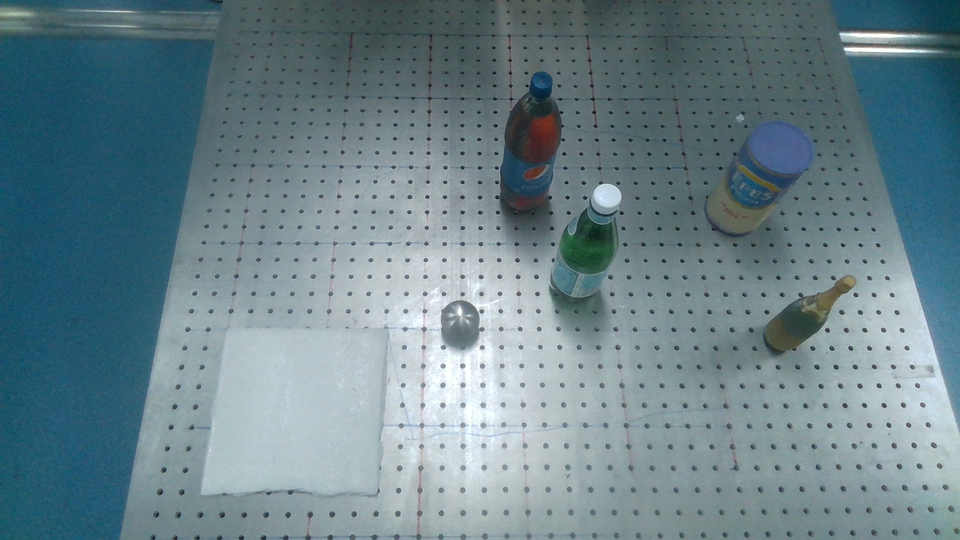

We have aligned a simulated scene to the above real scene for you. The code for building the simulated scene is provided as follow:

In [ ]:
if IN_COLAB:
    !gdown -q 1Y6D6gOZV_xjX3F49-taK7SwZtO6yQedf
    !unzip -o -q aligned.zip
    assets_dir = "."
else:
    assets_dir = "../assets"

def build_scene(sim, renderer):
    scene_config = sapien.SceneConfig()
    scene = sim.create_scene(scene_config)

    builder = scene.create_actor_builder()
    material = renderer.create_material()
    material.base_color = [1.0, 1.0, 1.0, 1.0]
    material.diffuse_texture_filename = os.path.join(assets_dir, "aligned/beer_can/texture.png")
    material.metallic = 0.001
    material.roughness = 0.4
    builder.add_visual_from_file(os.path.join(assets_dir, "aligned/beer_can/visual_mesh.obj"), material=material)
    beer_can = builder.build_kinematic()
    beer_can.set_pose(Pose([0.370301, -0.246856, 0.0738802], [0.922673, -0.00379302, -0.00852731, 0.385469]))

    builder = scene.create_actor_builder()
    material = renderer.create_material()
    material.base_color = [1.0, 1.0, 1.0, 1.0]
    material.diffuse_texture_filename = os.path.join(assets_dir, "aligned/champagne/texture.png")
    material.metallic = 0.01
    material.roughness = 0.2
    builder.add_visual_from_file(os.path.join(assets_dir, "aligned/champagne/visual_mesh.obj"), material=material)
    champagne = builder.build_kinematic()
    champagne.set_pose(Pose([0.182963, -0.277838, 0.0873777], [0.723872, 0.00616071, -0.00678847, -0.689874]))

    builder = scene.create_actor_builder()
    material = renderer.create_material()
    material.base_color = [1.0, 1.0, 1.0, 1.0]
    material.diffuse_texture_filename = os.path.join(assets_dir, "aligned/pepsi_bottle/texture.png")
    material.metallic = 0.001
    material.roughness = 0.6
    builder.add_visual_from_file(os.path.join(assets_dir, "aligned/pepsi_bottle/visual_mesh.obj"), material=material)
    pepsi_bottle = builder.build_kinematic()
    pepsi_bottle.set_pose(Pose([0.392403, 0.0504232, 0.116739], [0.991259, -0.00145631, -0.00922613, 0.131601]))

    builder = scene.create_actor_builder()
    material = renderer.create_material()
    material.base_color = [0.6, 0.6, 0.6, 1.0]
    material.metallic = 0.8
    material.roughness = 0.2
    builder.add_visual_from_file(os.path.join(assets_dir, "aligned/steel_ball/visual_mesh.obj"), material=material)
    steel_ball = builder.build_kinematic()
    steel_ball.set_pose(Pose([0.192034, 0.131187, 0.0170772], [0.949057, -0.0375225, 0.0676584, -0.305458]))

    builder = scene.create_actor_builder()
    builder.add_visual_from_file(os.path.join(assets_dir, "aligned/water_bottle/water_bottle.glb"))
    water_bottle = builder.build_kinematic()
    water_bottle.set_pose(Pose([0.256327, -0.0162116, -0.01], [0.00627772, -0.0093401, 0.000145366, 1.0008]))
    
    builder = scene.create_actor_builder()
    material = renderer.create_material()
    material.base_color = [1.0, 1.0, 1.0, 1.0]
    material.diffuse_texture_filename = os.path.join(assets_dir, "aligned/table/texture.png")
    material.metallic = 0.1
    material.roughness = 0.3
    builder.add_visual_from_file(os.path.join(assets_dir, "aligned/table/visual_mesh.obj"), material=material)
    table = builder.build_kinematic()
    table.set_pose(Pose([0.405808, 0.022201, -0.043524], [0.999921, -0.000290915, -0.00932814, 0.00842011]))

    scene.set_ambient_light([0., 0., 0.])
    scene.add_point_light([1.0, 0.2, 2.5], [10, 10, 10])
    scene.add_point_light([1.0, -2.7, 2.5], [10, 10, 10])
    scene.add_point_light([1.0, -5.6, 2.5], [10, 10, 10])
    scene.add_point_light([1.0, 3.1, 2.5], [10, 10, 10])
    scene.add_point_light([1.0, 6.0, 2.5], [10, 10, 10])

    return scene

Don't worry, we will soon let you see how the scene looks like in the simulated environment. Before that, let's construct the scene and add a `StereoDepthSensor` to it:

In [ ]:
# Construct the scene
scene = build_scene(sim, renderer)

# Create sensor
sensor_config = StereoDepthSensorConfig()
sensor = StereoDepthSensor('sensor', scene, sensor_config)

`StereoDepthSensor` supports a large number of configurable parameters to maximize its flexibility of simulating different sensors. For more information, Please check the API doc for class `StereoDepthSensorConfig`.

Optionally, you can mount the sensor to an existing actor:

    sensor_config = StereoDepthSensorConfig()
    sensor = StereoDepthSensor('sensor', scene, sensor_config, mount=actor, pose=Pose()) # pose is relative to mount

This works just like a mounted camera. Calling `sensor.set_local_pose` can adjust the relative pose to the mounted actor.

`sensor` behaves very similar to a camera. You can `set_pose` (or `set_local_pose` when mounted) and `take_picture` just like working with a camera. In addtion to these basic functions, you can `compute_depth` and `get_pointcloud` on the sensor:

In [ ]:
# Set sensor pose
sensor.set_pose(Pose([-0.13732728, 0.13584249, 0.82386769], [0.84667092, -0.01287458, 0.53195302, -0.00292851]))

scene.step()
scene.update_render()
sensor.take_picture()
sensor.compute_depth()

One important differences between camera and `sensor` is that while camera will only take picture of an RGB image, `sensor` will take another pair of infrared images, which will be used to compute depth. After calling `take_picture`, the RGB image and infrared images will be saved within `sensor`. Calling `sensor.get_rgb` and `sensor.get_ir` will return the pictures in ndarray form. Let’s take a look at them:

In [ ]:
rgb = sensor.get_rgb()
rgb_img = (rgb * 255).clip(0, 255).astype("uint8")
Image.fromarray(rgb_img).resize((960, 540))

In [ ]:
ir_l, ir_r = sensor.get_ir()
ir_l_img = (ir_l * 255).clip(0, 255).astype("uint8")
Image.fromarray(ir_l_img).resize((960, 540)) # Showing left infrared image

Calling `compute_depth` after `take_picture` will generate the depth map and save it within `sensor`. Similarly, we can get the computed depth ndarray by calling `sensor.get_depth`. Let’s compare our simulated depth with depth generated by real-world depth sensor:

*Depth map generated by real-world depth sensor:*

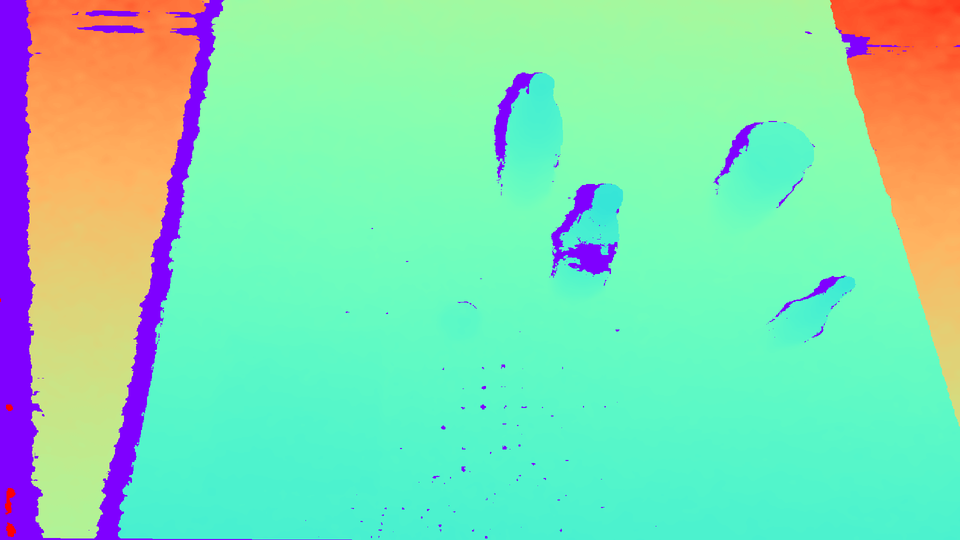

In [ ]:
depth = sensor.get_depth()

print("SAPIEN Realistic Depth:")
# Following code is to align the color map to the one used by real sensor
cmap = plt.get_cmap("rainbow")
depth = np.clip(depth / 2.0, 0.0, 1.0)
depth_img = cmap(depth)
depth_img = (depth_img[:, :, :3] * 255.0).astype(np.uint8)
Image.fromarray(depth_img).resize((960, 540))

> Note: The final depth map will be transformed into RGB camera frame, which means that it will have the same resolution and frame as of the RGB camera. This allows easy integration of RGBD image or RGB point cloud.

Finally, you can easily get a point cloud by calling `sensor.get_pointcloud`. You can choose if you want to fuse the pointcloud into a RGB point cloud (`[x, y, z, r, g, b]`) by specifying `with_rgb`. Let’s visualize the point cloud with Open3D:

In [ ]:
pc = sensor.get_pointcloud(with_rgb=True) # From RGB camera's view with x rightward, y downward, z forward
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pc[..., :3] * np.array([1, 1, -1]))) # Change axis direction for easier view
pcd.colors = o3d.utility.Vector3dVector(pc[..., 3:])
downpcd = pcd.voxel_down_sample(voxel_size=0.005)
o3d.visualization.draw_plotly([downpcd])

> Note: The point cloud will be from RGB camera’s view, with x-axis rightward, y-axis downward, and z-axis forward.

## Boosting Simulation Speed

The entire depth simulation pipeline in SAPIEN has been highly-optimized on GPU. It is possible to achieve real-time (60+ FPS) performance with `SteroDepthSensor` under certain resolution. Other than seamless GPU transfer, let’s see a few more tricks that can further boost the speed of `StereoDepthSensor`.

If depth is the only needed data and RGB data is not needed, you can specify `infrared_only` when calling `take_picture`:

    sensor.take_picture(infrared_only=True)

This can save the time for rendering RGB image.

As mentioned above, the final depth map generated by `StereoDepthSensor` will be transformed into RGB camera frame. It will be of the same resolution and frame as of the
RGB camera. This feature can be used to achieve fast downsampling/upsampling. All you need is to specify the `rgb_resolution` of the `StereoDepthSensorConfig` as the final
resolution you want to sample on, and `StereoDepthSensor` will do that for you on the GPU. In this way, you don't need to attach any slow CPU resampling function to it.

In general, lowering `ir_resolution` and `max_disp` of sensor config are all good ways to enhance computation speed. If you are using ray-tracing shader, lowering `rt_samples_per_pixel` of render config will also improve the speed by a large margin. However, note that these changes generally will have some effect (trade quality with speed) on the output depth map. You can freely adjust the parameters until you find the settings that satisfy your need.

## Seamless transfer to other GPU libraries

`StereoDepthSensor` can return output in DLPack tensor format. DLPack tensor is a common data format that has been adopted by many popular libraries such as PyTorch or TensorFlow. Through DLPack, the output depth map or point cloud can be seamlessly transferred into gpu tensors of those libraries without the need of additional CPU-GPU transfer. This further allows `StereoDepthSensor` to maximize its speed.

In addition, `StereoDepthSensor` has a function `get_depth_dl_tensor` that can return a DLPack tensor. Through DLPack, the output depth map can be seamlessly transferred into gpu tensors of common deep learning library such as PyTorch and TensorFlow. This can save the time for unnessecary GPU-to-CPU transfer. For example, directly passing the generated depth map from `StereoDepthSensor` to PyTorch without CPU-GPU transfer is as simple as two lines:

In [ ]:
if HAS_TORCH:
    depth_dl = sensor.get_depth_dl_tensor()
    depth_tensor = torch.utils.dlpack.from_dlpack(depth_dl).clone()

    print(depth_tensor.shape)

This also works for transferring point cloud:

In [ ]:
if HAS_TORCH:
    pointcloud_dl = sensor.get_pointcloud_dl_tensor()
    pointcloud_tensor = torch.utils.dlpack.from_dlpack(pointcloud_dl).clone()

    print(pointcloud_tensor.shape)

## Reference

[1] Zhang, X., Chen, R., Li, A., Xiang, F., Qin, Y., Gu, J., Ling, Z., Liu, M., Zeng, P., Han, S., Huang, Z., Mu, T., Xu, J., & Su, H. (2023). Close the Optical Sensing Domain Gap by Physics-Grounded Active Stereo Sensor Simulation. IEEE Transactions on Robotics, 1–19. https://doi.org/10.1109/TRO.2023.3235591